### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Apr 3rd at 11.59pm CST
---

In [188]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [125]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 

(1000, 2)
(1000,)


Text(0, 0.5, '$x_2$')

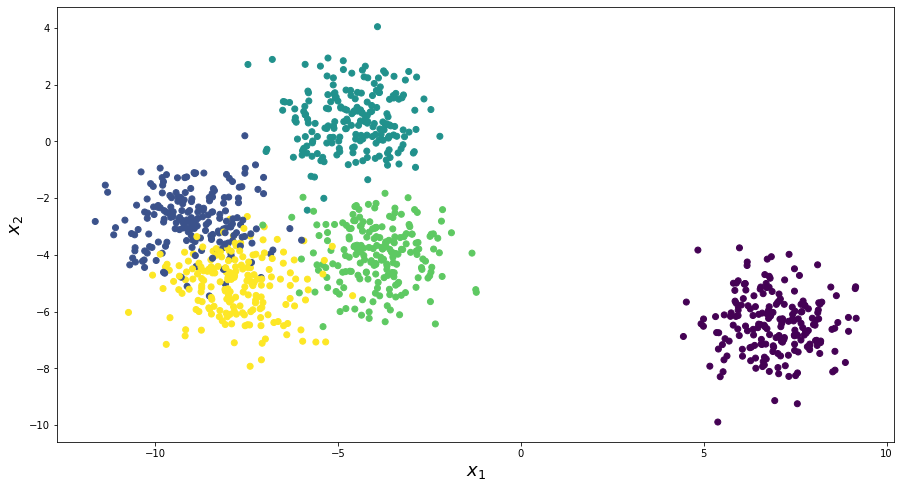

In [126]:
data=np.load('../../homeworks/hw_data/hw6_data_1.npy',allow_pickle=True)
X=data[:,:2]
y=data[:,2]
print(X.shape)
print(y.shape)

plt.scatter(X[:,0],X[:,1],c=y)
plt.xlabel(r'$x_1$',fontsize=18)
plt.ylabel(r'$x_2$',fontsize=18)

2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 

In [127]:
bwrange = np.linspace(0.1,1, num=30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(X) 
h_opt = grid.best_params_['bandwidth']
print("Optimal bandwidth: {:.2f}".format(h_opt))

Optimal bandwidth: 0.47


<ipython-input-128-e0e564c09aed>:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


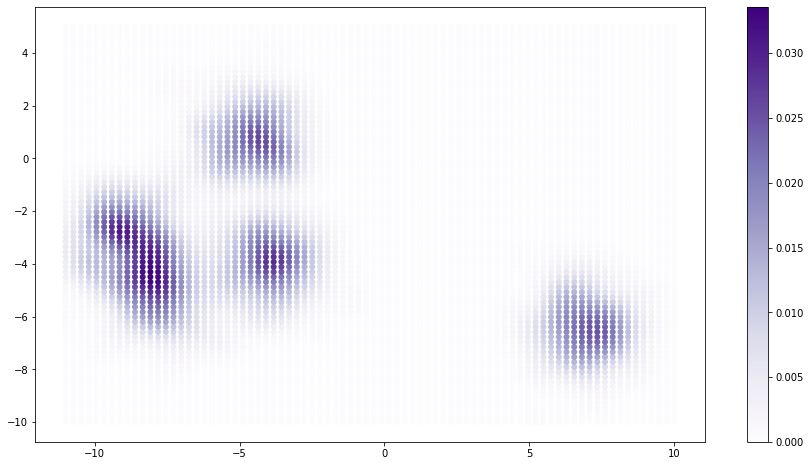

In [128]:
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) 

u = np.linspace(-11,10,80)
v = np.linspace(-10,5,80)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?

<font color='red'>You need roughly k>=6 to make the plot look similar to KDE</font>

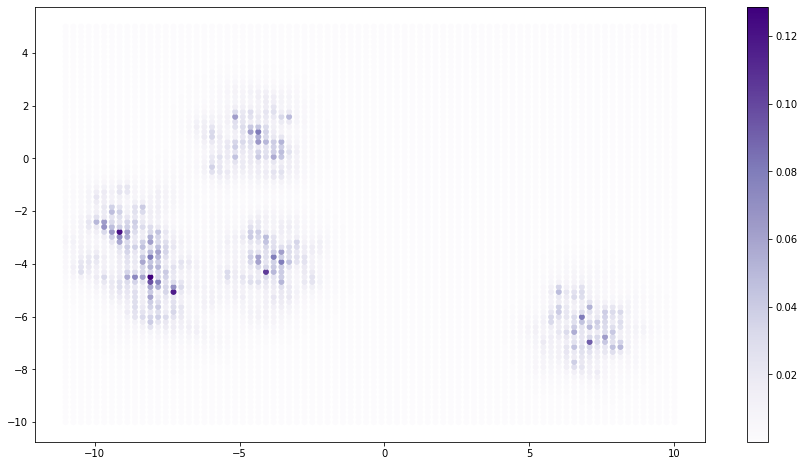

In [129]:
N=X.shape[0]
k=6

nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X)
dens = nbrs.eval(Xgrid)/N

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

SRT: I think even k=6 still looks very granular and not close to the underlying distribution. The density value in the color bar is also very different from the KDE distribution. It needs at least ~50. -1

4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

Optimal Number of GMM Components by BIC: 4


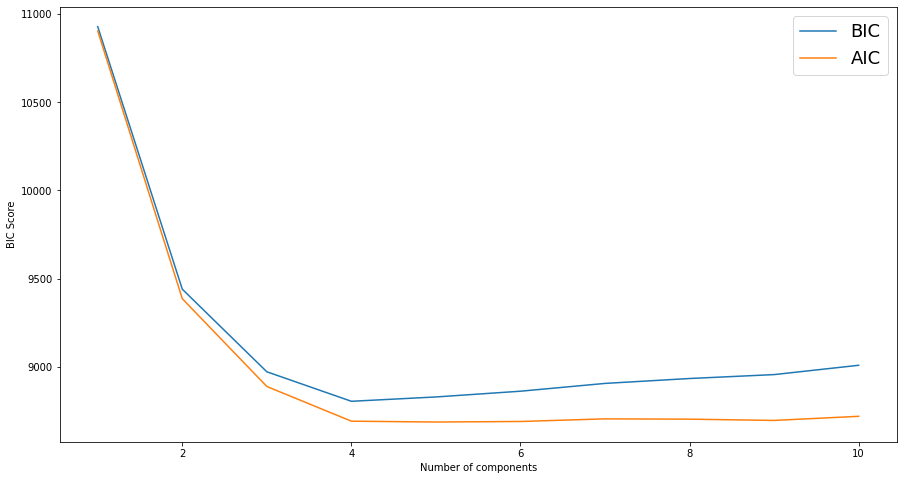

In [130]:
BIC = []
AIC = []
for ii in range(1,11):
    gmm = GaussianMixture(ii)
    gmm.fit(X)
    log_dens = gmm.score(X)
    BIC.append(gmm.bic(X))
    AIC.append(gmm.aic(X))
    
print('Optimal Number of GMM Components by BIC: {:.0f}'.format(np.arange(1,11)[np.argmin(BIC)]))
    
plt.plot(np.arange(1,11), BIC,label='BIC');
plt.plot(np.arange(1,11), AIC, label='AIC');
plt.xlabel('Number of components');
plt.ylabel('BIC Score');
plt.legend(loc='best',fontsize=18)
plt.show()

[[-8.40670335 -3.92008982]
 [ 6.93608907 -6.42286837]
 [-4.59965863  0.74087316]
 [-3.97032879 -3.98919389]]
(2,)
(2, 2)


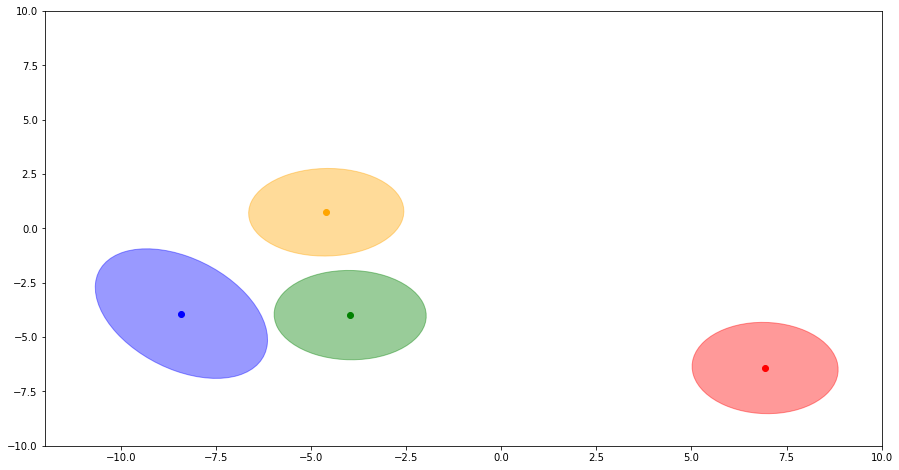

In [131]:
n_comp=4 #4 components
gmm = GaussianMixture(n_comp) 
gmm.fit(X)

mus=gmm.means_
print(mus)
print(mus[0].shape)
Cs=gmm.covariances_
print(Cs[0].shape)

colors=['b','r','orange','g']

plt.axis([-12,10,-10,10])
for n in range(n_comp):
    plt.scatter(mus[n,0],mus[n,1],c=colors[n])
    draw_ellipse(mus[n], Cs[n], sigmas=[2],color=colors[n],alpha=0.4)


SRT: Looks great. You just need the data set plotted here as well. -1

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

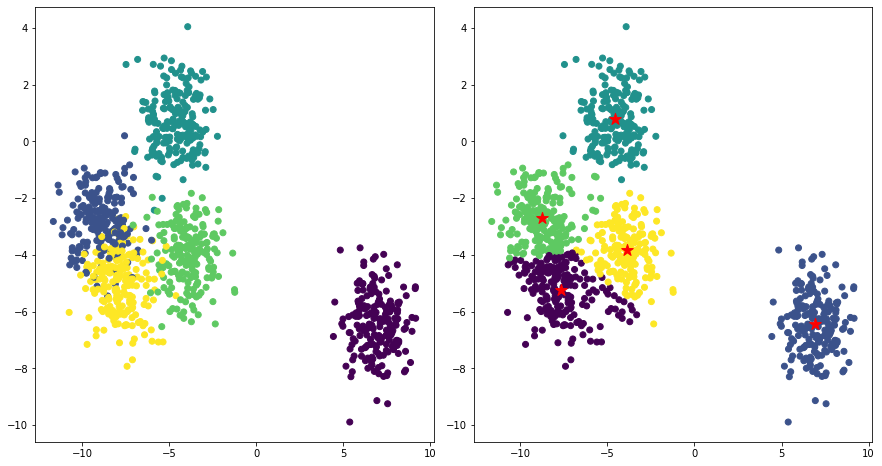

In [142]:
n_clusters = 5
# Use the StandardScaler to scale the data
scaler = preprocessing.StandardScaler()
X_scaled=scaler.fit_transform(X)

# Fit the K-means model
clf = KMeans(n_clusters)
clf.fit(X_scaled)

# Find the cluster centers
centers_scaled=clf.cluster_centers_

# Inverse transform these centers back to the original unscaled coordinates
centers=scaler.inverse_transform(centers_scaled)

# Predict the labels for the scaled data
y_pred=clf.predict(X_scaled)

# Make a two-panel side by side plot showing
fig,axs=plt.subplots(nrows=1,ncols=2)

# (a) the original data colored by its labels
axs[0].scatter(X[:,0],X[:,1],c=y)

# (b) the data colored by the Kmeans predicted labels, with cluster centers superposed
axs[1].scatter(X[:,0],X[:,1],c=y_pred)
for i in range(n_clusters):
    axs[1].scatter(centers[i,0],centers[i,1],s=150,c='r',marker='*')

    
plt.subplots_adjust(wspace=0.1)



---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [145]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?pca = PCA(n_components=4) # n_components can be optionally set
pca.fit(X) 


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?

In [149]:
pca = PCA(n_components=2)
pca.fit(X) 

print("Ratio of variance in data explained by eigen-features: {:.2f}".format(sum(pca.explained_variance_ratio_)))

Ratio of variance in data explained by eigen-features: 0.78


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.

<font color='red'>fetch_imaging_sample() sends an SQL query to SDSS which draws from PhotoTag. From the Schema Browser we can see that type has entries of 0,1,2,3,4,5,6,7,8,9 corresponding to UNKNOWN, COSMIC_RAY, DEFECT, GALAXY, GHOST, KNOWN_OBJ, STAR, TRAIL, SKY, NOTATYPE, respectively. We can see from the cell below that all of our objects are labelled as either stars or galaxies</font>

In [174]:
labels=data['type']
label_names=['UNKNOWN','COSMIC_RAY','DEFECT','GALAXY','GHOST','KNOWN_OBJ','STAR','TRAIL','SKY','NOTATYPE']
for i in labels[:10]:
    print(label_names[i])
    
for i in labels:
    if ((i!=3)and(i!=6)):
        print("WARNING SOME OBJECTS ARE NOT STARS OR GALAXIES")
        
# Transform labels to 0->galaxy and 1->star to make plotting later easier
for i in range(len(labels)):
    if labels[i]==3:
        labels[i]=0
    if labels[i]==6:
        labels[i]=1
label_names=['Galaxy','Star']

GALAXY
STAR
GALAXY
STAR
GALAXY
GALAXY
GALAXY
GALAXY
GALAXY
STAR


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*

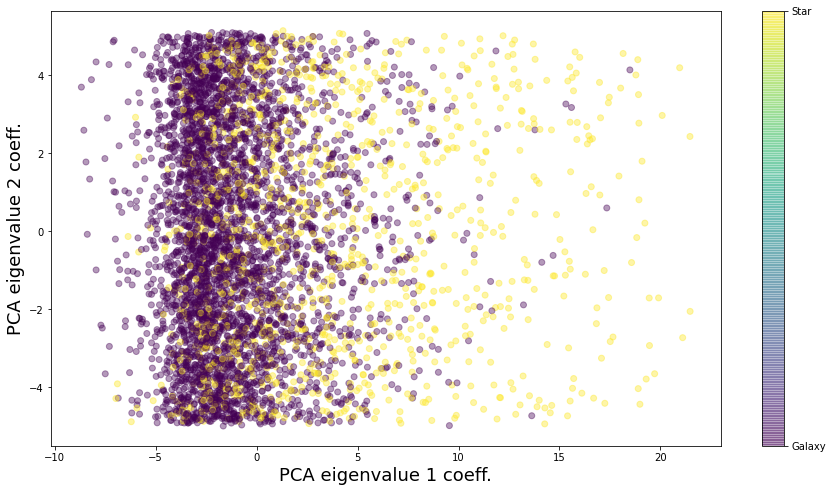

In [177]:
N=len(labels)
N_choose=5000

idx_choose=np.random.choice(np.arange(N),size=N_choose,replace=False)
X_choose=X[idx_choose,:]
y_choose=labels[idx_choose]

X_choose_reduced=pca.transform(X_choose)

plt.scatter(X_choose_reduced[:,0],X_choose_reduced[:,1],c=y_choose,alpha=0.4)
plt.xlabel('PCA eigenvalue 1 coeff.',fontsize=18)
plt.ylabel('PCA eigenvalue 2 coeff.',fontsize=18)

# below borrowed from https://gist.github.com/jakevdp/8a992f606899ac24b711
# Coincidentally, this was written by Jake Vanderplas

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: label_names[val])

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[0,1], format=formatter);



5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

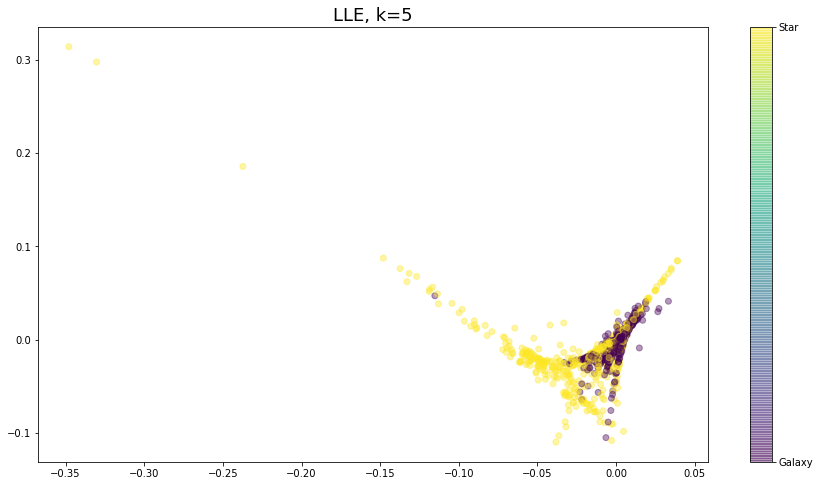

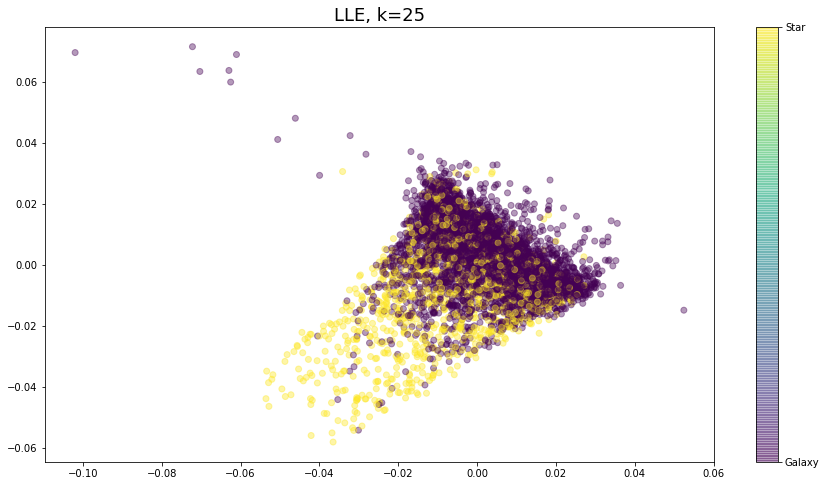

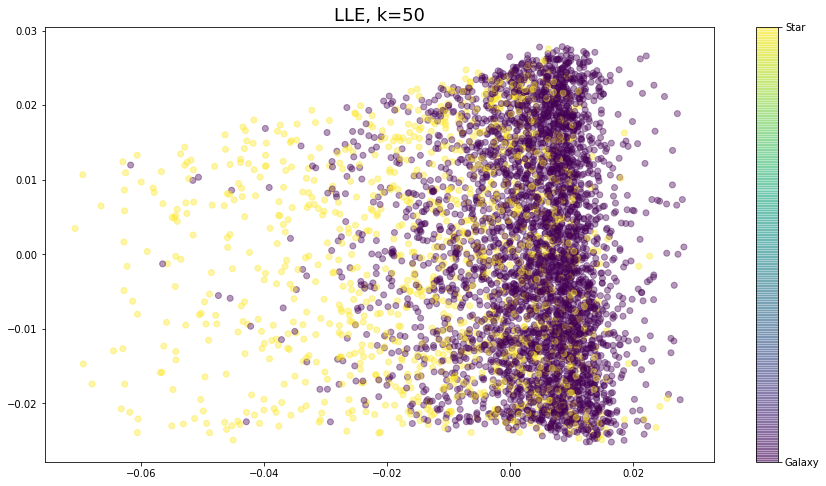

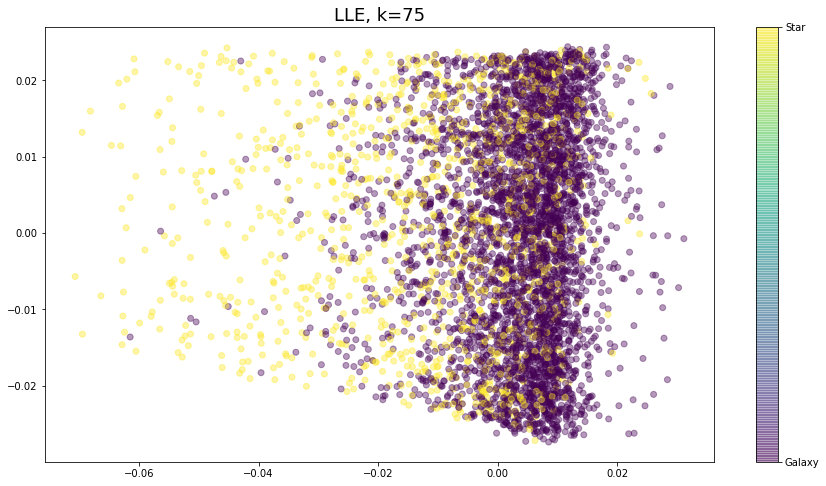

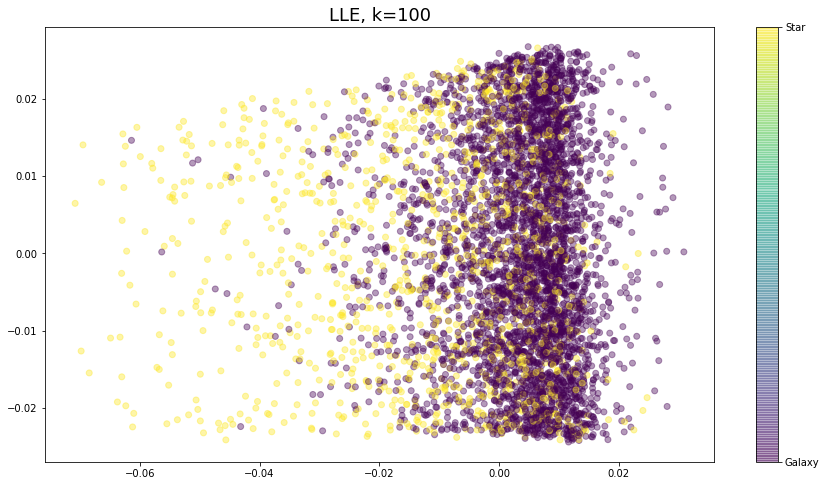

In [183]:
n = 2 # Number of dimensions to fit

k_tries=[5,25,50,75,100] # Number of neighbors to use in fit

for k in k_tries:

    lle = LocallyLinearEmbedding(n_neighbors=k, 
                                 n_components=n)
    lle.fit(X_choose)
    proj = lle.transform(X_choose) # 5000x2 projection of the data

    plt.scatter(proj[:,0],proj[:,1],c=y_choose,alpha=0.4)

    formatter = plt.FuncFormatter(lambda val, loc: label_names[val])
    plt.colorbar(ticks=[0,1], format=formatter);
    plt.title('LLE, k='+str(k),fontsize=18)
    plt.show()

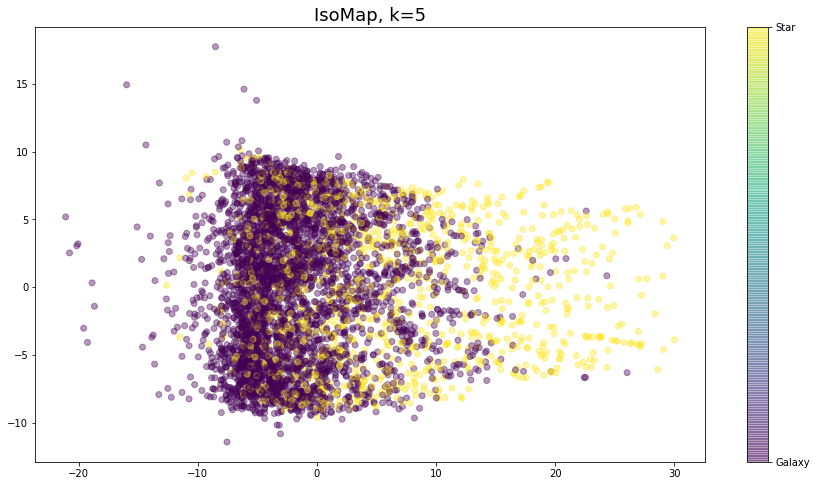

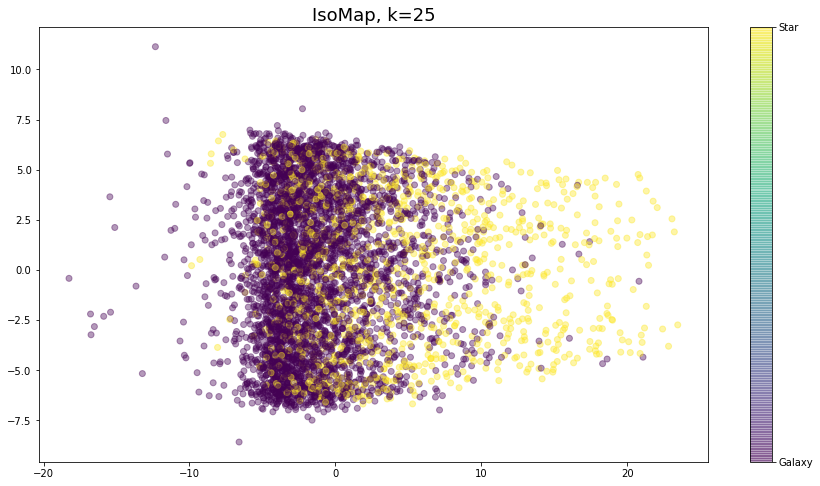

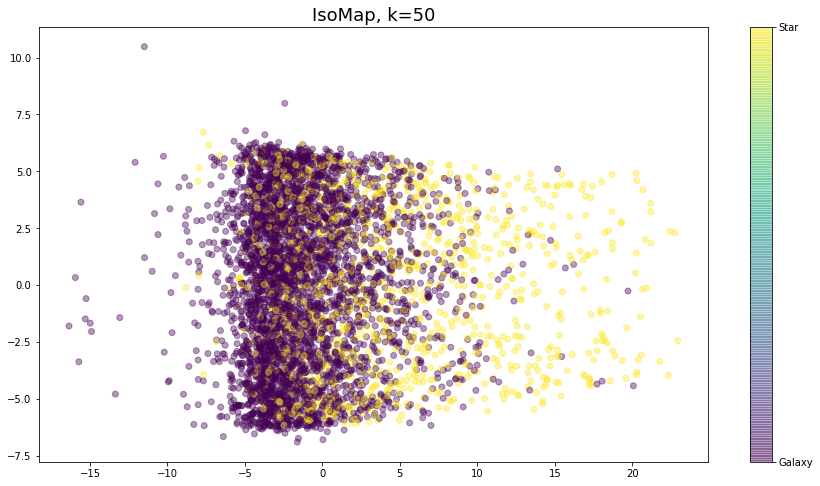

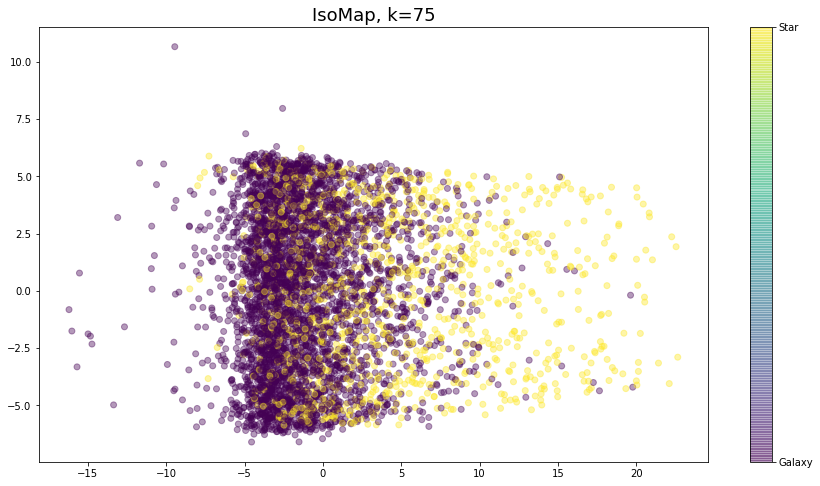

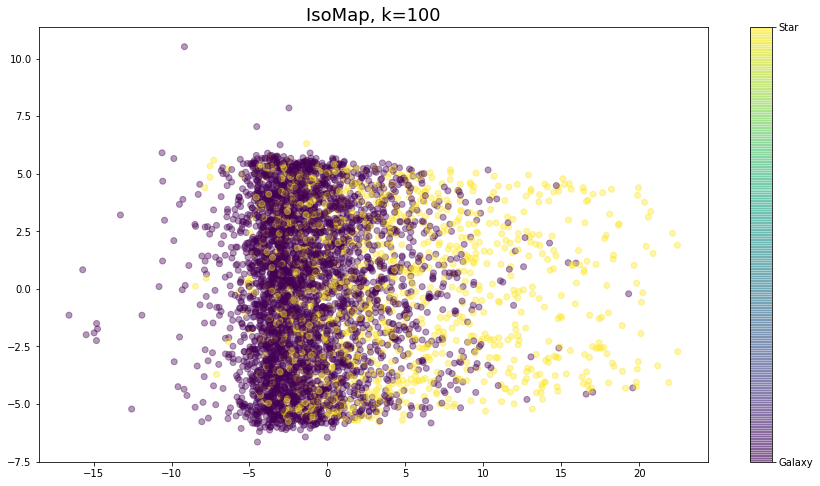

In [187]:
n = 2 # Number of dimensions to fit

k_tries=[5,25,50,75,100] # Number of neighbors to use in fit

for k in k_tries:

    iso = Isomap(n_neighbors=k, n_components=n)
    iso.fit(X_choose)
    proj = iso.transform(X_choose) # 5000x2 projection of the data

    plt.scatter(proj[:,0],proj[:,1],c=y_choose,alpha=0.4)

    formatter = plt.FuncFormatter(lambda val, loc: label_names[val])
    plt.colorbar(ticks=[0,1], format=formatter);
    plt.title('IsoMap, k='+str(k),fontsize=18)
    plt.show()

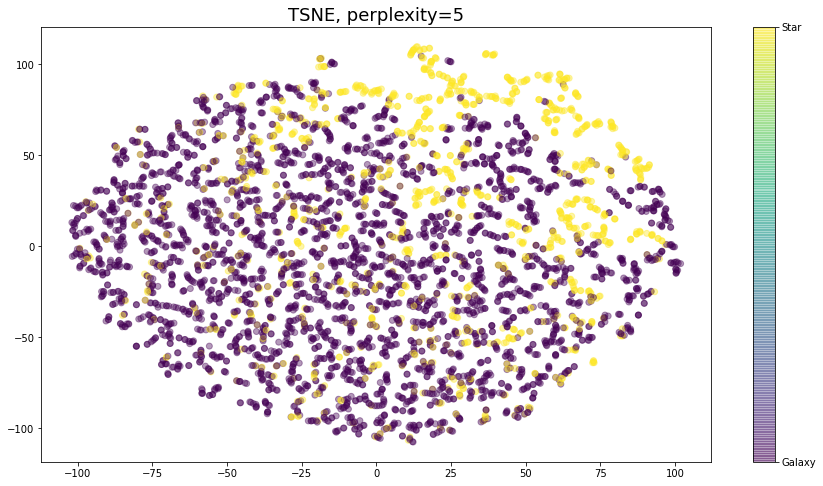

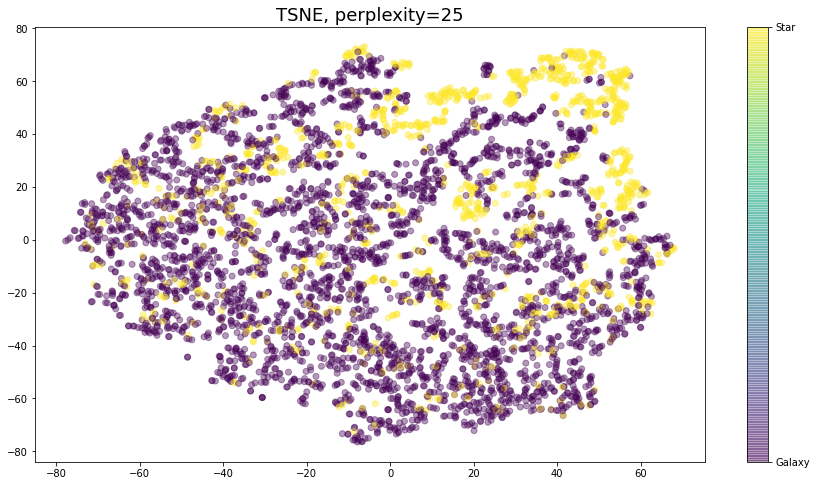

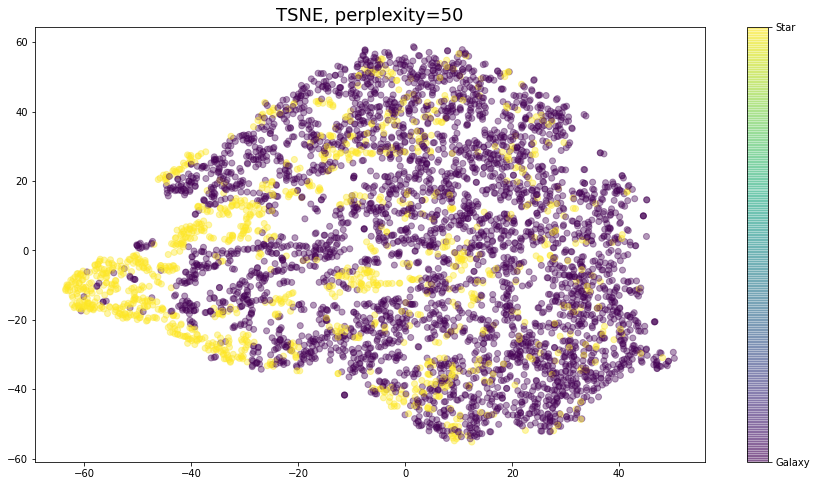

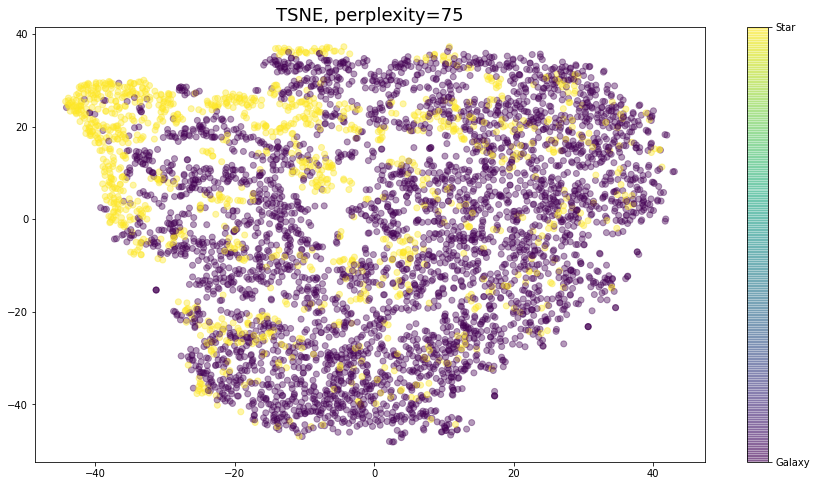

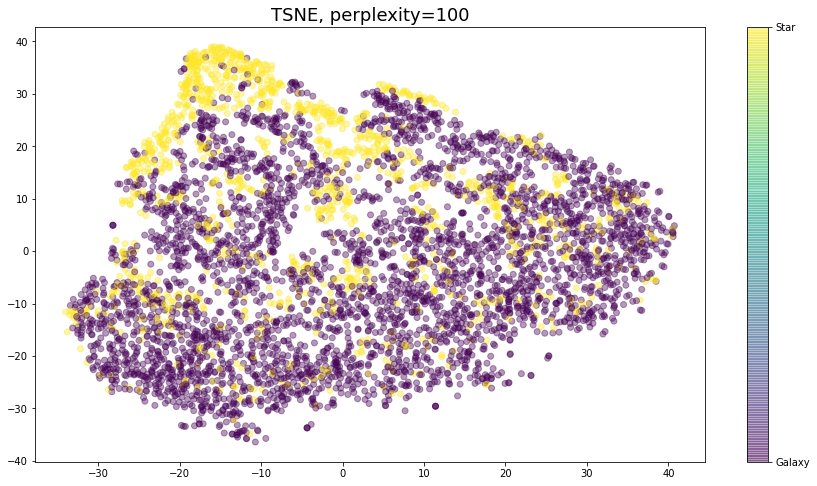

In [189]:
n = 2 # Number of dimensions to fit

k_tries=[5,25,50,75,100] # Number of neighbors to use in fit

for k in k_tries:

    tsne = TSNE(perplexity=k,n_components=n)
    proj = tsne.fit_transform(X_choose)

    plt.scatter(proj[:,0],proj[:,1],c=y_choose,alpha=0.4)

    formatter = plt.FuncFormatter(lambda val, loc: label_names[val])
    plt.colorbar(ticks=[0,1], format=formatter);
    plt.title('TSNE, perplexity='+str(k),fontsize=18)
    plt.show()

<font color='red'>  It looks like TSNE with perplexity>=50 gives the strongest separation between classes</font>